In [1]:
from quantecon import compute_fixed_point

import numpy as np
from collections import namedtuple
from numba import njit


# NamedTuple Model
Model = namedtuple("Model", ("β", "K", "c", "κ", "p"))


def create_inventory_model(β=0.98,      # discount factor
                           K=40,        # maximum inventory
                           c=0.2, κ=2,  # cost parameters
                           p=0.6):      # demand parameter
    return Model(β=β, K=K, c=c, κ=κ, p=p)


@njit
def demand_pdf(d, p):
    return (1 - p)**d * p


@njit
def B(x, a, v, model, d_max=101):
    """
    The function B(x, a, v) = r(x, a) + β Σ_x′ v(x′) P(x, a, x′).
    """
    β, K, c, κ, p = model
    x1 = np.array([np.minimum(x, d)*demand_pdf(d, p) for d in np.arange(d_max)])
    reward = np.sum(x1) - c * a - κ * (a > 0)
    x2 = np.array([v[np.maximum(0, x - d) + a] * demand_pdf(d, p)
                                 for d in np.arange(d_max)])
    continuation_value = β * np.sum(x2)
    return reward + continuation_value


@njit
def T(v, model):
    """The Bellman operator."""
    β, K, c, κ, p = model
    new_v = np.empty_like(v)
    for x in range(0, K+1):
        x1 = np.array([B(x, a, v, model) for a in np.arange(K-x+1)])
        new_v[x] = np.max(x1)
    return new_v


@njit
def get_greedy(v, model):
    """
    Get a v-greedy policy.  Returns a zero-based array.
    """
    β, K, c, κ, p = model
    σ_star = np.zeros(K+1, dtype=np.int32)
    for x in range(0, K+1):
        x1 = np.array([B(x, a, v, model) for a in np.arange(K-x+1)])
        σ_star[x] = np.argmax(x1)
    return σ_star


def solve_inventory_model(v_init, model):
    """Use successive_approx to get v_star and then compute greedy."""
    β, K, c, κ, p = model
    v_star = compute_fixed_point(lambda v: T(v, model), v_init,
                                 error_tol=1e-5, max_iter=1000, print_skip=25)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star


# == Plots == #

import matplotlib.pyplot as plt


# Create an instance of the model and solve it
model = create_inventory_model()
β, K, c, κ, p = model
v_init = np.zeros(K+1)
v_star, σ_star = solve_inventory_model(v_init, model)


def sim_inventories(ts_length=400, X_init=0):
    """Simulate given the optimal policy."""
    global p, σ_star
    X = np.zeros(ts_length, dtype=np.int32)
    X[0] = X_init
    # Subtracts 1 because numpy generates only positive integers
    rand = np.random.default_rng().geometric(p=p, size=ts_length-1) - 1
    for t in range(0, ts_length-1):
        X[t+1] = np.maximum(X[t] - rand[t], 0) + σ_star[X[t] + 1]
    return X


def plot_vstar_and_opt_policy(fontsize=10,
                   figname="../figures/inventory_dp_vs.pdf",
                   savefig=False):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6.5))

    ax = axes[0]
    ax.plot(np.arange(K+1), v_star, label=r"$v^*$")
    ax.set_ylabel("value", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)

    ax = axes[1]
    ax.plot(np.arange(K+1), σ_star, label=r"$\sigma^*$")
    ax.set_xlabel("inventory", fontsize=fontsize)
    ax.set_ylabel("optimal choice", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    if savefig:
        fig.savefig(figname)


def plot_ts(fontsize=10,
            figname="../figures/inventory_dp_ts.pdf",
            savefig=False):
    X = sim_inventories()
    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.plot(X, label="$X_t$", alpha=0.7)
    ax.set_xlabel("$t$", fontsize=fontsize)
    ax.set_ylabel("inventory", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, np.max(X)+4)
    if savefig:
        fig.savefig(figname)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------


25           4.104e-01      1.601e+00         
50           2.102e-01      1.635e+00         
75           9.558e-02      1.668e+00         
100          5.715e-02      1.715e+00         
125          3.436e-02      1.755e+00         
150          2.070e-02      1.796e+00         
175          1.249e-02      1.838e+00         
200          7.532e-03      1.869e+00         


225          4.545e-03      1.918e+00         
250          2.743e-03      1.966e+00         
275          1.655e-03      2.005e+00         
300          9.987e-04      2.044e+00         
325          6.027e-04      2.071e+00         
350          3.637e-04      2.119e+00         
375          2.195e-04      2.157e+00         
400          1.324e-04      2.183e+00         
425          7.993e-05      2.217e+00         
450          4.823e-05      2.265e+00         
475          2.911e-05      2.296e+00         
500          1.757e-05      2.336e+00         
525          1.060e-05      2.369e+00         
528          9.977e-06      2.369e+00         
Converged in 528 steps


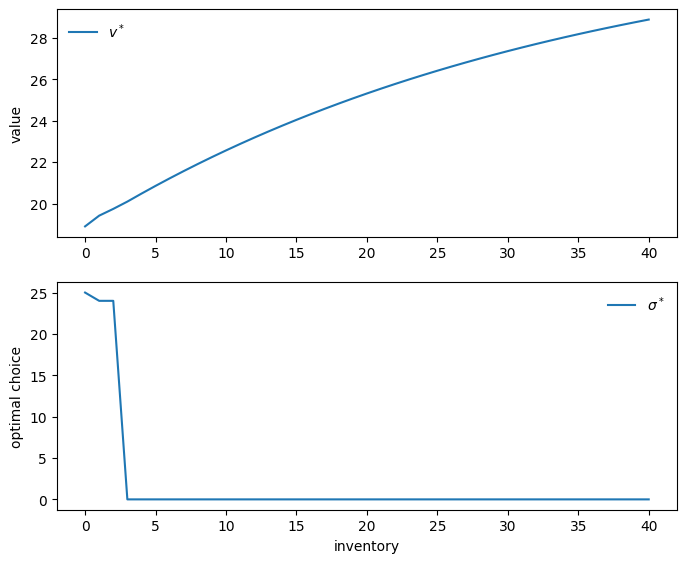

In [2]:
plot_vstar_and_opt_policy(savefig=True)

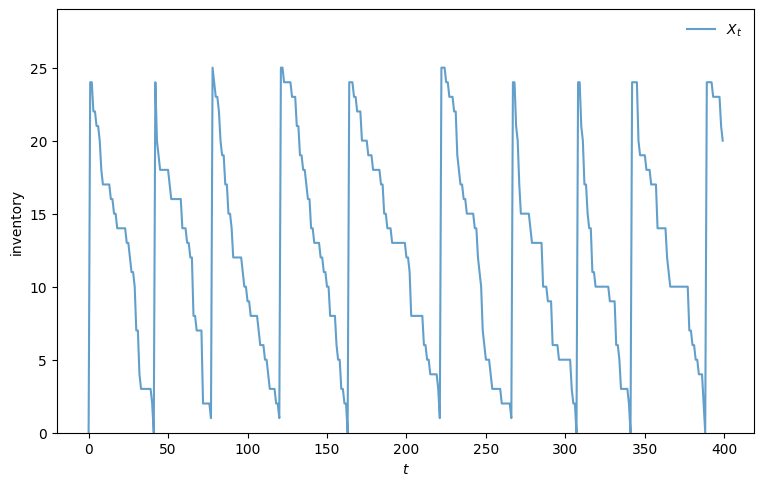

In [3]:
plot_ts(savefig=True)

In [4]:
from quantecon.markov import tauchen
import numpy as np
from collections import namedtuple
from numba import njit, prange


# NamedTuple Model
Model = namedtuple("Model", ("β", "R", "γ", "w_grid", "y_grid", "Q"))


def create_savings_model(R=1.01, β=0.98, γ=2.5,
                         w_min=0.01, w_max=20.0, w_size=200,
                         ρ=0.9, ν=0.1, y_size=5):
    w_grid = np.linspace(w_min, w_max, w_size)
    mc = tauchen(y_size, ρ, ν)
    y_grid, Q = np.exp(mc.state_values), mc.P
    return Model(β=β, R=R, γ=γ, w_grid=w_grid, y_grid=y_grid, Q=Q)


@njit
def U(c, γ):
    return c**(1-γ)/(1-γ)


@njit
def B(i, j, k, v, model):
    """
    B(w, y, w′, v) = u(R*w + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′).
    """
    β, R, γ, w_grid, y_grid, Q = model
    w, y, w_1 = w_grid[i], y_grid[j], w_grid[k]
    c = w + y - (w_1 / R)
    value = -np.inf
    if c > 0:
        value = U(c, γ) + β * np.dot(v[k, :], Q[j, :])
    return value


@njit(parallel=True)
def T(v, model):
    """The Bellman operator."""
    β, R, γ, w_grid, y_grid, Q = model
    v_new = np.empty_like(v)
    for i in prange(w_grid.shape[0]):
        for j in prange(y_grid.shape[0]):
            x_tmp = np.array([B(i, j, k, v, model) for k
                              in np.arange(w_grid.shape[0])])
            v_new[i, j] = np.max(x_tmp)
    return v_new


@njit(parallel=True)
def T_σ(v, σ, model):
    """The policy operator."""
    β, R, γ, w_grid, y_grid, Q = model
    v_new = np.empty_like(v)
    for i in prange(w_grid.shape[0]):
        for j in prange(y_grid.shape[0]):
            v_new[i, j] = B(i, j, σ[i, j], v, model)
    return v_new

In [5]:
import numpy as np
from finite_opt_saving_0 import U, B
from numba import njit, prange
from itertools import product


@njit(parallel=True)
def get_greedy(v, model):
    """Compute a v-greedy policy."""
    β, R, γ, w_grid, y_grid, Q = model
    σ = np.empty((w_grid.shape[0], y_grid.shape[0]), dtype=np.int32)
    for i in prange(w_grid.shape[0]):
        for j in prange(y_grid.shape[0]):
            x_tmp = np.array([B(i, j, k, v, model) for k in
                             np.arange(w_grid.shape[0])])
            σ[i, j] = np.argmax(x_tmp)
    return σ


@njit
def single_to_multi(m, yn):
    # Function to extract (i, j) from m = i + (j-1)*yn
    return (m//yn, m%yn)


@njit(parallel=True)
def get_value(σ, model):
    """Get the value v_σ of policy σ."""
    # Unpack and set up
    β, R, γ, w_grid, y_grid, Q = model
    w_idx, y_idx = np.arange(len(w_grid)), np.arange(len(y_grid))
    wn, yn = len(w_grid), len(y_grid)
    n = wn * yn
    # Build P_σ and r_σ as multi-index arrays
    P_σ = np.zeros((wn, yn, wn, yn))
    r_σ = np.zeros((wn, yn))
    for (i, j) in product(w_idx, y_idx):
        w, y, w_1 = w_grid[i], y_grid[j], w_grid[σ[i, j]]
        r_σ[i, j] = U(w + y - w_1/R, γ)
        for (i_1, j_1) in product(w_idx, y_idx):
            if i_1 == σ[i, j]:
                P_σ[i, j, i_1, j_1] = Q[j, j_1]

    # Solve for the value of σ
    I = np.identity(n)
    v_σ = np.linalg.solve((I - β * P_σ), r_σ)
    # Return as multi-index array
    v_σ = v_σ.reshape(wn, yn)
    return v_σ


In [6]:
from quantecon import compute_fixed_point

import numpy as np
from numba import njit
import time
from finite_opt_saving_1 import get_greedy, get_value
from finite_opt_saving_0 import create_savings_model, T, T_σ
from quantecon import MarkovChain


def value_iteration(model, tol=1e-5):
    """Value function iteration routine."""
    vz = np.zeros((len(model.w_grid), len(model.y_grid)))
    v_star = compute_fixed_point(lambda v: T(v, model), vz,
                                 error_tol=tol, max_iter=1000, print_skip=25)
    return get_greedy(v_star, model)


@njit
def policy_iteration(model):
    """Howard policy iteration routine."""
    wn, yn = len(model.w_grid), len(model.y_grid)
    σ = np.ones((wn, yn), dtype=np.int32)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = np.max(np.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error: {error}.")
    return σ


@njit
def optimistic_policy_iteration(model, tolerance=1e-5, m=100):
    """Optimistic policy iteration routine."""
    v = np.zeros((len(model.w_grid), len(model.y_grid)))
    error = tolerance + 1
    while error > tolerance:
        last_v = v
        σ = get_greedy(v, model)
        for i in range(0, m):
            v = T_σ(v, σ, model)
        error = np.max(np.abs(v - last_v))
    return get_greedy(v, model)

# Simulations and inequality measures

def simulate_wealth(m):

    model = create_savings_model()
    σ_star = optimistic_policy_iteration(model)
    β, R, γ, w_grid, y_grid, Q = model

    # Simulate labor income (indices rather than grid values)
    mc = MarkovChain(Q)
    y_idx_series = mc.simulate(ts_length=m)

    # Compute corresponding wealth time series
    w_idx_series = np.empty_like(y_idx_series)
    w_idx_series[0] = 1  # initial condition
    for t in range(m-1):
        i, j = w_idx_series[t], y_idx_series[t]
        w_idx_series[t+1] = σ_star[i, j]
    w_series = w_grid[w_idx_series]

    return w_series

def lorenz(v):  # assumed sorted vector
    S = np.cumsum(v)  # cumulative sums: [v[1], v[1] + v[2], ... ]
    F = np.arange(1, len(v) + 1) / len(v)
    L = S / S[-1]
    return (F, L) # returns named tuple

gini = lambda v: (2 * sum(i * y for (i, y) in enumerate(v))/sum(v) - (len(v) + 1))/len(v)

# Plots

import matplotlib.pyplot as plt


def plot_timing(m_vals=np.arange(1, 601, 10),
                savefig=False):
    model = create_savings_model(y_size=5)
    print("Running Howard policy iteration.")
    t1 = time.time()
    σ_pi = policy_iteration(model)
    pi_time = time.time() - t1
    print(f"PI completed in {pi_time} seconds.")
    print("Running value function iteration.")
    t1 = time.time()
    σ_vfi = value_iteration(model)
    vfi_time = time.time() - t1
    print(f"VFI completed in {vfi_time} seconds.")

    assert np.allclose(σ_vfi, σ_pi), "Warning: policies deviated."

    opi_times = []
    for m in m_vals:
        print(f"Running optimistic policy iteration with m={m}.")
        t1 = time.time()
        σ_opi = optimistic_policy_iteration(model, m=m)
        t2 = time.time()
        assert np.allclose(σ_opi, σ_pi), "Warning: policies deviated."
        print(f"OPI with m={m} completed in {t2-t1} seconds.")
        opi_times.append(t2-t1)

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(m_vals, [vfi_time]*len(m_vals),
            linewidth=2, label="value function iteration")
    ax.plot(m_vals, [pi_time]*len(m_vals),
            linewidth=2, label="Howard policy iteration")
    ax.plot(m_vals, opi_times, linewidth=2,
            label="optimistic policy iteration")
    ax.legend(frameon=False)
    ax.set_xlabel(r"$m$")
    ax.set_ylabel("time")
    if savefig:
        fig.savefig("../figures/finite_opt_saving_2_1.png")
    return (pi_time, vfi_time, opi_times)


def plot_policy(method="pi", savefig=False):
    model = create_savings_model()
    β, R, γ, w_grid, y_grid, Q = model
    if method == "vfi":
        σ_star =  value_iteration(model)
    elif method == "pi":
        σ_star = policy_iteration(model)
    else:
        method = "OPT"
        σ_star = optimistic_policy_iteration(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_grid, w_grid, "k--", label=r"$45$")
    ax.plot(w_grid, w_grid[σ_star[:, 0]], label=r"$\sigma^*(\cdot, y_1)$")
    ax.plot(w_grid, w_grid[σ_star[:, -1]], label=r"$\sigma^*(\cdot, y_N)$")
    ax.legend()
    plt.title(f"Method: {method}")
    if savefig:
        fig.savefig(f"../figures/finite_opt_saving_2_2_{method}.png")

def plot_time_series(m=2_000, savefig=False):

    w_series = simulate_wealth(m)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_series, label="w_t")
    ax.set_xlabel("time")
    ax.legend()
    if savefig:
        fig.savefig("../figures/finite_opt_saving_ts.pdf")

def plot_histogram(m=1_000_000, savefig=False):

    w_series = simulate_wealth(m)
    g = round(gini(w_series.sort()), ndigits=2)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.hist(w_series, bins=40, density=True)
    ax.set_xlabel("wealth")
    ax.text(15, 0.4, "Gini = $g")

    if savefig:
        fig.savefig("../figures/finite_opt_saving_hist.pdf")

def plot_lorenz(m=1_000_000, savefig=False):

    w_series = simulate_wealth(m)
    (F, L) = lorenz(w_series.sort())

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(F, F, label="Lorenz curve, equality")
    ax.plot(F, L, label="Lorenz curve, wealth distribution")
    ax.legend()

    if savefig:
        fig.savefig("../figures/finite_opt_saving_lorenz.pdf")

In [7]:
plot_timing(savefig=True)

Running Howard policy iteration.


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'product':[0m [1m[1mCannot determine Numba type of <class 'type'>[0m
[1m
File "finite_opt_saving_1.py", line 37:[0m
[1mdef get_value(σ, model):
    <source elided>
    r_σ = np.zeros((wn, yn))
[1m    for (i, j) in product(w_idx, y_idx):
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function get_value at 0x0000020366FD9760>))[0m
[0m[1mDuring: typing of call at C:\Users\orect\AppData\Local\Temp\ipykernel_13580\2892945003.py (26)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function get_value at 0x0000020366FD9760>))[0m
[0m[1mDuring: typing of call at C:\Users\orect\AppData\Local\Temp\ipykernel_13580\2892945003.py (26)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function get_value at 0x0000020366FD9760>))[0m
[0m[1mDuring: typing of call at C:\Users\orect\AppData\Local\Temp\ipykernel_13580\2892945003.py (26)
[0m
[1m
File "C:\Users\orect\AppData\Local\Temp\ipykernel_13580\2892945003.py", line 26:[0m
[1mdef policy_iteration(model):
    <source elided>
    while error > 0:
[1m        v_σ = get_value(σ, model)
[0m        [1m^[0m[0m


In [8]:
plot_policy()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'product':[0m [1m[1mCannot determine Numba type of <class 'type'>[0m
[1m
File "finite_opt_saving_1.py", line 37:[0m
[1mdef get_value(σ, model):
    <source elided>
    r_σ = np.zeros((wn, yn))
[1m    for (i, j) in product(w_idx, y_idx):
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function get_value at 0x0000020366FD9760>))[0m
[0m[1mDuring: typing of call at C:\Users\orect\AppData\Local\Temp\ipykernel_13580\2892945003.py (26)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function get_value at 0x0000020366FD9760>))[0m
[0m[1mDuring: typing of call at C:\Users\orect\AppData\Local\Temp\ipykernel_13580\2892945003.py (26)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function get_value at 0x0000020366FD9760>))[0m
[0m[1mDuring: typing of call at C:\Users\orect\AppData\Local\Temp\ipykernel_13580\2892945003.py (26)
[0m
[1m
File "C:\Users\orect\AppData\Local\Temp\ipykernel_13580\2892945003.py", line 26:[0m
[1mdef policy_iteration(model):
    <source elided>
    while error > 0:
[1m        v_σ = get_value(σ, model)
[0m        [1m^[0m[0m


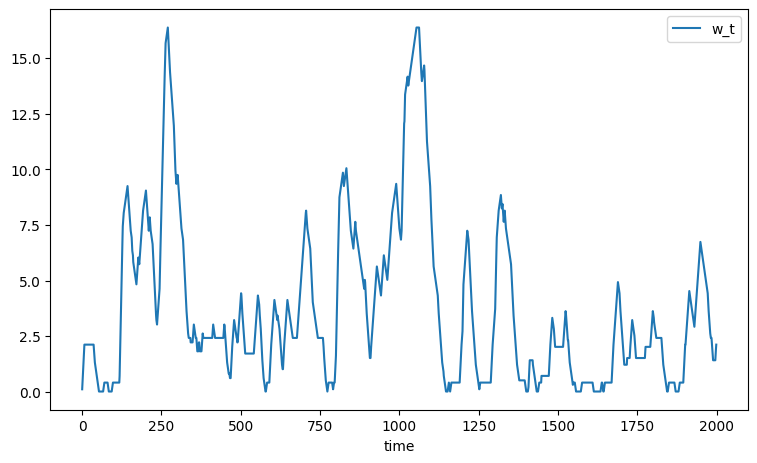

In [9]:
plot_time_series(savefig=True)

In [10]:
plot_histogram(savefig=True)

TypeError: 'NoneType' object is not iterable

In [11]:
plot_lorenz(savefig=True)

TypeError: object of type 'NoneType' has no len()

In [12]:
from quantecon import compute_fixed_point
from quantecon.markov import tauchen, MarkovChain

import numpy as np
from collections import namedtuple
from numba import njit, prange
import time


# NamedTuple Model
Model = namedtuple("Model", ("β", "a_0", "a_1", "γ", "c",
                             "y_grid", "z_grid", "Q"))


def create_investment_model(
        r=0.04,                               # Interest rate
        a_0=10.0, a_1=1.0,                    # Demand parameters
        γ=25.0, c=1.0,                        # Adjustment and unit cost
        y_min=0.0, y_max=20.0, y_size=100,    # Grid for output
        ρ=0.9, ν=1.0,                         # AR(1) parameters
        z_size=25):                           # Grid size for shock
    β = 1/(1+r)
    y_grid = np.linspace(y_min, y_max, y_size)
    mc = tauchen(y_size, ρ, ν)
    z_grid, Q = mc.state_values, mc.P
    return Model(β=β, a_0=a_0, a_1=a_1, γ=γ, c=c,
          y_grid=y_grid, z_grid=z_grid, Q=Q)


@njit
def B(i, j, k, v, model):
    """
    The aggregator B is given by

        B(y, z, y′) = r(y, z, y′) + β Σ_z′ v(y′, z′) Q(z, z′)."

    where

        r(y, z, y′) := (a_0 - a_1 * y + z - c) y - γ * (y′ - y)^2

    """
    β, a_0, a_1, γ, c, y_grid, z_grid, Q = model
    y, z, y_1 = y_grid[i], z_grid[j], y_grid[k]
    r = (a_0 - a_1 * y + z - c) * y - γ * (y_1 - y)**2
    return r + β * np.dot(v[k, :], Q[j, :])


@njit(parallel=True)
def T_σ(v, σ, model):
    """The policy operator."""
    v_new = np.empty_like(v)
    for i in prange(len(model.y_grid)):
        for j in prange(len(model.z_grid)):
            v_new[i, j] = B(i, j, σ[i, j], v, model)
    return v_new


@njit(parallel=True)
def T(v, model):
    """The Bellman operator."""
    v_new = np.empty_like(v)
    for i in prange(len(model.y_grid)):
        for j in prange(len(model.z_grid)):
            tmp = np.array([B(i, j, k, v, model) for k
                            in np.arange(len(model.y_grid))])
            v_new[i, j] = np.max(tmp)
    return v_new


@njit(parallel=True)
def get_greedy(v, model):
    """Compute a v-greedy policy."""
    n, m = len(model.y_grid), len(model.z_grid)
    σ = np.empty((n, m), dtype=np.int32)
    for i in prange(n):
        for j in prange(m):
            tmp = np.array([B(i, j, k, v, model) for k
                            in np.arange(n)])
            σ[i, j] = np.argmax(tmp)
    return σ



def value_iteration(model, tol=1e-5):
    """Value function iteration routine."""
    vz = np.zeros((len(model.y_grid), len(model.z_grid)))
    v_star = compute_fixed_point(lambda v: T(v, model), vz,
                                 error_tol=tol, max_iter=1000, print_skip=25)
    return get_greedy(v_star, model)


@njit
def single_to_multi(m, zn):
    # Function to extract (i, j) from m = i + (j-1)*zn
    return (m//zn, m%zn)


@njit(parallel=True)
def get_value(σ, model):
    """Get the value v_σ of policy σ."""
    # Unpack and set up
    β, a_0, a_1, γ, c, y_grid, z_grid, Q = model
    yn, zn = len(y_grid), len(z_grid)
    n = yn * zn
    # Allocate and create single index versions of P_σ and r_σ
    P_σ = np.zeros((n, n))
    r_σ = np.zeros(n)
    for m in prange(n):
        i, j = single_to_multi(m, zn)
        y, z, y_1 = y_grid[i], z_grid[j], y_grid[σ[i, j]]
        r_σ[m] = (a_0 - a_1 * y + z - c) * y - γ * (y_1 - y)**2
        for m_1 in prange(n):
            i_1, j_1 = single_to_multi(m_1, zn)
            if i_1 == σ[i, j]:
                P_σ[m, m_1] = Q[j, j_1]

    I = np.identity(n)
    # Solve for the value of σ
    v_σ = np.linalg.solve((I - β * P_σ), r_σ)
    # Return as multi-index array
    v_σ = v_σ.reshape(yn, zn)
    return v_σ


@njit
def policy_iteration(model):
    """Howard policy iteration routine."""
    yn, zn = len(model.y_grid), len(model.z_grid)
    σ = np.ones((yn, zn), dtype=np.int32)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = np.max(np.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error: {error}.")
    return σ


@njit
def optimistic_policy_iteration(model, tol=1e-5, m=100):
    """Optimistic policy iteration routine."""
    v = np.zeros((len(model.y_grid), len(model.z_grid)))
    error = tol + 1
    while error > tol:
        last_v = v
        σ = get_greedy(v, model)
        for i in range(m):
            v = T_σ(v, σ, model)
        error = np.max(np.abs(v - last_v))
    return get_greedy(v, model)


# Plots

import matplotlib.pyplot as plt


def plot_policy(savefig=False, figname="../figures/finite_lq_0.pdf"):
    model = create_investment_model()
    β, a_0, a_1, γ, c, y_grid, z_grid, Q = model
    σ_star = optimistic_policy_iteration(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(y_grid, y_grid, "k--", label=r"$45$")
    ax.plot(y_grid, y_grid[σ_star[:, 0]], label=r"$\sigma^*(\cdot, z_1)$")
    ax.plot(y_grid, y_grid[σ_star[:, -1]], label="$\sigma^*(\cdot, z_N)$")
    ax.legend()
    if savefig:
        fig.savefig(figname)


def plot_sim(savefig=False, figname="../figures/finite_lq_1.pdf"):
    ts_length = 200

    fig, axes = plt.subplots(4, 1, figsize=(9, 11.2))

    for (ax, γ) in zip(axes, (1, 10, 20, 30)):
        model = create_investment_model(γ=γ)
        β, a_0, a_1, γ, c, y_grid, z_grid, Q = model
        σ_star = optimistic_policy_iteration(model)
        mc = MarkovChain(Q, z_grid)

        z_sim_idx = mc.simulate_indices(ts_length)
        z_sim = z_grid[z_sim_idx]

        y_sim_idx = np.empty(ts_length, dtype=np.int32)
        y_1 = (a_0 - c + z_sim[1]) / (2 * a_1)

        y_sim_idx[0] = np.searchsorted(y_grid, y_1)
        for t in range(ts_length-1):
            y_sim_idx[t+1] = σ_star[y_sim_idx[t], z_sim_idx[t]]
        y_sim = y_grid[y_sim_idx]
        y_bar_sim = (a_0 - c + z_sim) / (2 * a_1)

        ax.plot(np.arange(1, ts_length+1), y_sim, label=r"$Y_t$")
        ax.plot(np.arange(1, ts_length+1), y_bar_sim, label=r"$\bar Y_t$")
        ax.legend(frameon=False, loc="upper right")
        ax.set_ylabel("output")
        ax.set_ylim(1, 9)
        ax.set_title(r"$\gamma = $" + f"{γ}")

    fig.tight_layout()
    if savefig:
        fig.savefig(figname)


def plot_timing(m_vals=np.arange(1, 601, 10),
                savefig=False,
                figname="../figures/finite_lq_time.pdf"
    ):
    # NOTE: Uncomment the following lines in this function to
    # include Policy iteration plot
    model = create_investment_model()
    # print("Running Howard policy iteration.")
    # t1 = time.time()
    # σ_pi = policy_iteration(model)
    # pi_time = time.time() - t1
    # print(f"PI completed in {pi_time} seconds.")
    print("Running value function iteration.")
    t1 = time.time()
    σ_vfi = value_iteration(model)
    vfi_time = time.time() - t1
    print(f"VFI completed in {vfi_time} seconds.")
    opi_times = []
    for m in m_vals:
        print(f"Running optimistic policy iteration with m={m}.")
        t1 = time.time()
        σ_opi = optimistic_policy_iteration(model, m=m, tol=1e-5)
        t2 = time.time()
        print(f"OPI with m={m} completed in {t2-t1} seconds.")
        opi_times.append(t2-t1)

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(m_vals, [vfi_time]*len(m_vals),
            linewidth=2, label="value function iteration")
    # ax.plot(m_vals, [pi_time]*len(m_vals),
    #         linewidth=2, label="Howard policy iteration")
    ax.plot(m_vals, opi_times, linewidth=2, label="optimistic policy iteration")
    ax.legend(frameon=False)
    ax.set_xlabel(r"$m$")
    ax.set_ylabel("time")
    if savefig:
        fig.savefig(figname)
    return (vfi_time, opi_times)

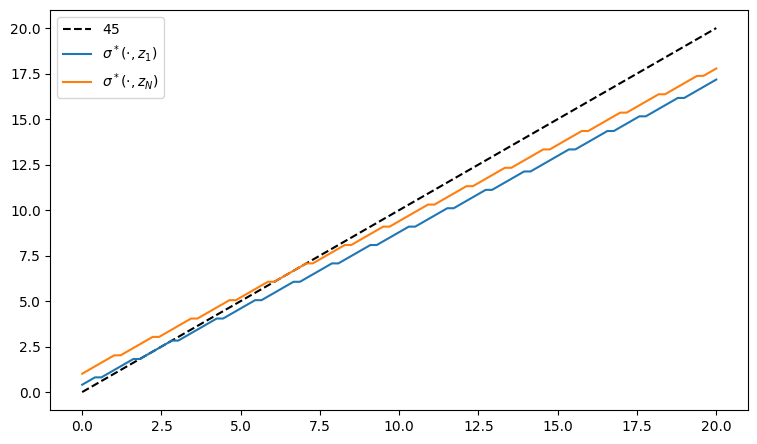

In [13]:
plot_policy()

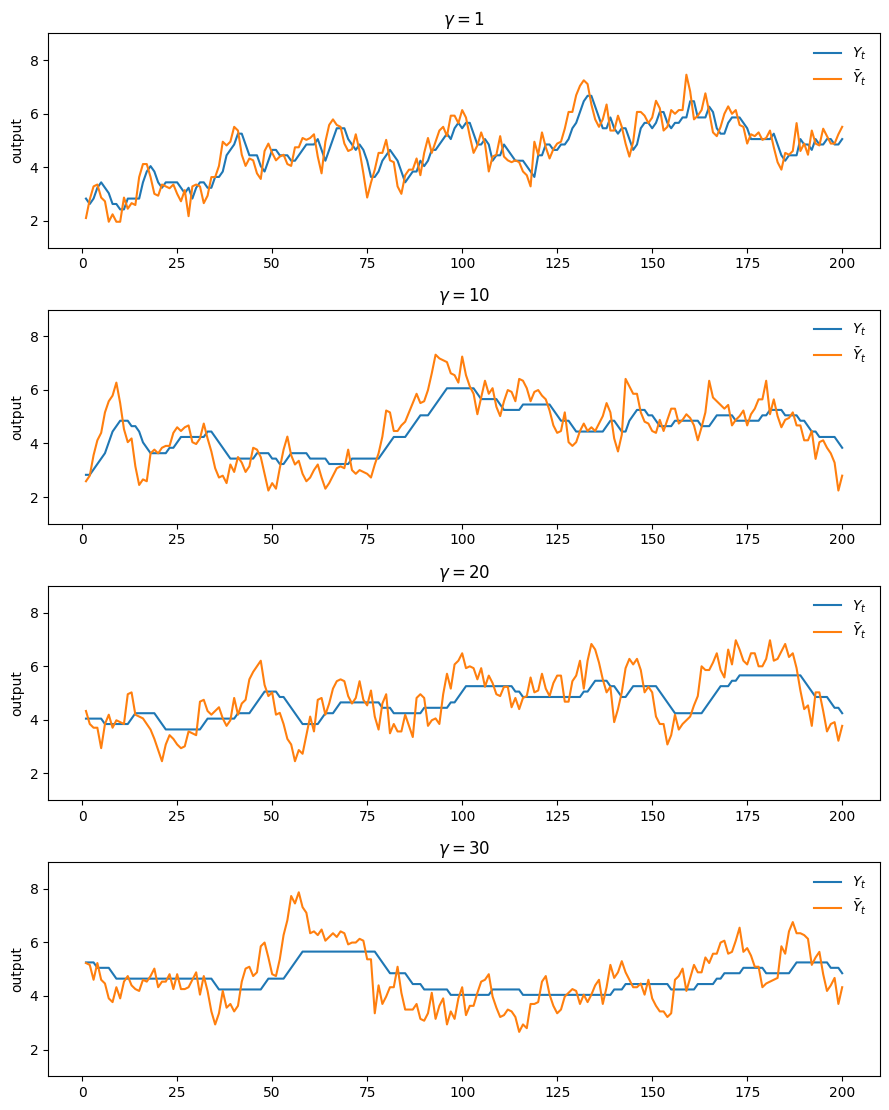

In [14]:
plot_sim(savefig=True)

Running value function iteration.
Iteration    Distance       Elapsed (seconds)
---------------------------------------------


25           8.945e+00      1.606e+00         


50           3.040e+00      2.141e+00         


75           1.132e+00      2.606e+00         


100          4.246e-01      3.073e+00         


125          1.593e-01      3.537e+00         


150          5.974e-02      4.002e+00         


175          2.241e-02      4.467e+00         


200          8.406e-03      4.939e+00         


225          3.153e-03      5.412e+00         


250          1.183e-03      5.883e+00         


275          4.437e-04      6.441e+00         


300          1.664e-04      6.927e+00         


325          6.244e-05      7.426e+00         


350          2.342e-05      7.902e+00         


372          9.883e-06      8.298e+00         
Converged in 372 steps
VFI completed in 8.317303657531738 seconds.
Running optimistic policy iteration with m=1.


OPI with m=1 completed in 7.705800294876099 seconds.
Running optimistic policy iteration with m=11.


OPI with m=11 completed in 0.9312241077423096 seconds.
Running optimistic policy iteration with m=21.


OPI with m=21 completed in 0.524613618850708 seconds.
Running optimistic policy iteration with m=31.


OPI with m=31 completed in 0.6309833526611328 seconds.
Running optimistic policy iteration with m=41.


OPI with m=41 completed in 0.37549853324890137 seconds.
Running optimistic policy iteration with m=51.


OPI with m=51 completed in 0.323650598526001 seconds.
Running optimistic policy iteration with m=61.


OPI with m=61 completed in 0.3668208122253418 seconds.
Running optimistic policy iteration with m=71.


OPI with m=71 completed in 0.3247509002685547 seconds.
Running optimistic policy iteration with m=81.


OPI with m=81 completed in 0.33099913597106934 seconds.
Running optimistic policy iteration with m=91.


OPI with m=91 completed in 0.463407039642334 seconds.
Running optimistic policy iteration with m=101.


OPI with m=101 completed in 0.5621151924133301 seconds.
Running optimistic policy iteration with m=111.


OPI with m=111 completed in 0.3889293670654297 seconds.
Running optimistic policy iteration with m=121.


OPI with m=121 completed in 0.44277429580688477 seconds.
Running optimistic policy iteration with m=131.


OPI with m=131 completed in 0.4202611446380615 seconds.
Running optimistic policy iteration with m=141.


OPI with m=141 completed in 0.43380117416381836 seconds.
Running optimistic policy iteration with m=151.


OPI with m=151 completed in 0.5007362365722656 seconds.
Running optimistic policy iteration with m=161.


OPI with m=161 completed in 0.5629949569702148 seconds.
Running optimistic policy iteration with m=171.


OPI with m=171 completed in 0.5623066425323486 seconds.
Running optimistic policy iteration with m=181.


OPI with m=181 completed in 0.6399619579315186 seconds.
Running optimistic policy iteration with m=191.


OPI with m=191 completed in 0.6409530639648438 seconds.
Running optimistic policy iteration with m=201.


OPI with m=201 completed in 0.6890718936920166 seconds.
Running optimistic policy iteration with m=211.


OPI with m=211 completed in 0.5390331745147705 seconds.
Running optimistic policy iteration with m=221.


OPI with m=221 completed in 0.5723419189453125 seconds.
Running optimistic policy iteration with m=231.


OPI with m=231 completed in 0.5723471641540527 seconds.
Running optimistic policy iteration with m=241.


OPI with m=241 completed in 0.5972495079040527 seconds.
Running optimistic policy iteration with m=251.


OPI with m=251 completed in 0.5885002613067627 seconds.
Running optimistic policy iteration with m=261.


OPI with m=261 completed in 0.6794464588165283 seconds.
Running optimistic policy iteration with m=271.


OPI with m=271 completed in 0.6881828308105469 seconds.
Running optimistic policy iteration with m=281.


OPI with m=281 completed in 0.6838271617889404 seconds.
Running optimistic policy iteration with m=291.


OPI with m=291 completed in 0.6975750923156738 seconds.
Running optimistic policy iteration with m=301.


OPI with m=301 completed in 0.719301700592041 seconds.
Running optimistic policy iteration with m=311.


OPI with m=311 completed in 0.7251858711242676 seconds.
Running optimistic policy iteration with m=321.


OPI with m=321 completed in 0.7656257152557373 seconds.
Running optimistic policy iteration with m=331.


OPI with m=331 completed in 0.789837121963501 seconds.
Running optimistic policy iteration with m=341.


OPI with m=341 completed in 0.8964087963104248 seconds.
Running optimistic policy iteration with m=351.


OPI with m=351 completed in 0.8231747150421143 seconds.
Running optimistic policy iteration with m=361.


OPI with m=361 completed in 0.8407490253448486 seconds.
Running optimistic policy iteration with m=371.


OPI with m=371 completed in 0.8682880401611328 seconds.
Running optimistic policy iteration with m=381.


OPI with m=381 completed in 0.9425203800201416 seconds.
Running optimistic policy iteration with m=391.


OPI with m=391 completed in 1.081928014755249 seconds.
Running optimistic policy iteration with m=401.


OPI with m=401 completed in 1.0679411888122559 seconds.
Running optimistic policy iteration with m=411.


OPI with m=411 completed in 1.1959724426269531 seconds.
Running optimistic policy iteration with m=421.


OPI with m=421 completed in 1.0063669681549072 seconds.
Running optimistic policy iteration with m=431.


OPI with m=431 completed in 1.0556316375732422 seconds.
Running optimistic policy iteration with m=441.


OPI with m=441 completed in 1.0233290195465088 seconds.
Running optimistic policy iteration with m=451.


OPI with m=451 completed in 1.0233221054077148 seconds.
Running optimistic policy iteration with m=461.


OPI with m=461 completed in 1.1686656475067139 seconds.
Running optimistic policy iteration with m=471.


OPI with m=471 completed in 1.0803754329681396 seconds.
Running optimistic policy iteration with m=481.


OPI with m=481 completed in 1.159712791442871 seconds.
Running optimistic policy iteration with m=491.


OPI with m=491 completed in 1.097865343093872 seconds.
Running optimistic policy iteration with m=501.


OPI with m=501 completed in 1.1125457286834717 seconds.
Running optimistic policy iteration with m=511.


OPI with m=511 completed in 1.0783131122589111 seconds.
Running optimistic policy iteration with m=521.


OPI with m=521 completed in 1.1742053031921387 seconds.
Running optimistic policy iteration with m=531.


OPI with m=531 completed in 1.0798242092132568 seconds.
Running optimistic policy iteration with m=541.


OPI with m=541 completed in 1.2539124488830566 seconds.
Running optimistic policy iteration with m=551.


OPI with m=551 completed in 1.0972256660461426 seconds.
Running optimistic policy iteration with m=561.


OPI with m=561 completed in 1.2188184261322021 seconds.
Running optimistic policy iteration with m=571.


OPI with m=571 completed in 1.1996078491210938 seconds.
Running optimistic policy iteration with m=581.


OPI with m=581 completed in 1.3466198444366455 seconds.
Running optimistic policy iteration with m=591.


OPI with m=591 completed in 1.2662878036499023 seconds.


(8.317303657531738,
 [7.705800294876099,
  0.9312241077423096,
  0.524613618850708,
  0.6309833526611328,
  0.37549853324890137,
  0.323650598526001,
  0.3668208122253418,
  0.3247509002685547,
  0.33099913597106934,
  0.463407039642334,
  0.5621151924133301,
  0.3889293670654297,
  0.44277429580688477,
  0.4202611446380615,
  0.43380117416381836,
  0.5007362365722656,
  0.5629949569702148,
  0.5623066425323486,
  0.6399619579315186,
  0.6409530639648438,
  0.6890718936920166,
  0.5390331745147705,
  0.5723419189453125,
  0.5723471641540527,
  0.5972495079040527,
  0.5885002613067627,
  0.6794464588165283,
  0.6881828308105469,
  0.6838271617889404,
  0.6975750923156738,
  0.719301700592041,
  0.7251858711242676,
  0.7656257152557373,
  0.789837121963501,
  0.8964087963104248,
  0.8231747150421143,
  0.8407490253448486,
  0.8682880401611328,
  0.9425203800201416,
  1.081928014755249,
  1.0679411888122559,
  1.1959724426269531,
  1.0063669681549072,
  1.0556316375732422,
  1.02332901954

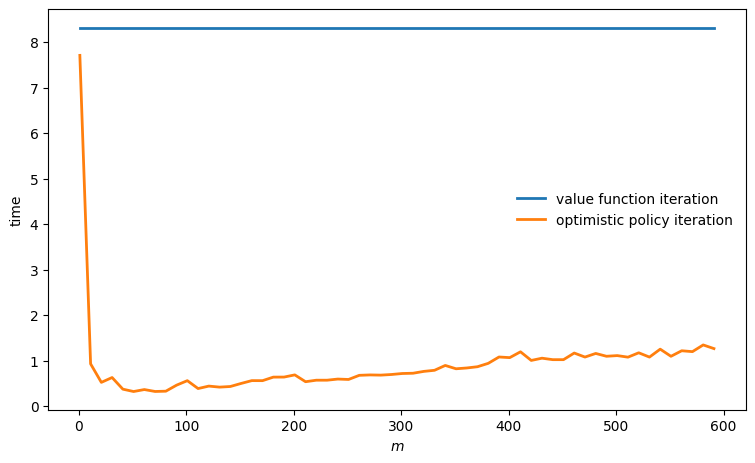

In [15]:
plot_timing(savefig=True)

In [16]:
import numpy as np
from quantecon.markov import tauchen, MarkovChain

from collections import namedtuple
from numba import njit, prange


# NamedTuple Model
Model = namedtuple("Model", ("β", "κ", "α", "p", "w", "l_grid",
                             "z_grid", "Q"))


def create_hiring_model(
        r=0.04,                              # Interest rate
        κ=1.0,                               # Adjustment cost
        α=0.4,                               # Production parameter
        p=1.0, w=1.0,                        # Price and wage
        l_min=0.0, l_max=30.0, l_size=100,   # Grid for labor
        ρ=0.9, ν=0.4, b=1.0,                 # AR(1) parameters
        z_size=100):                         # Grid size for shock
    β = 1/(1+r)
    l_grid = np.linspace(l_min, l_max, l_size)
    mc = tauchen(z_size, ρ, ν, b, 6)
    z_grid, Q = mc.state_values, mc.P
    return Model(β=β, κ=κ, α=α, p=p, w=w,
                 l_grid=l_grid, z_grid=z_grid, Q=Q)


@njit
def B(i, j, k, v, model):
    """
    The aggregator B is given by

        B(l, z, l′) = r(l, z, l′) + β Σ_z′ v(l′, z′) Q(z, z′)."

    where

        r(l, z, l′) := p * z * f(l) - w * l - κ 1{l != l′}

    """
    β, κ, α, p, w, l_grid, z_grid, Q = model
    l, z, l_1 = l_grid[i], z_grid[j], l_grid[k]
    r = p * z * l**α - w * l - κ * (l != l_1)
    return r + β * np.dot(v[k, :], Q[j, :])


@njit(parallel=True)
def T_σ(v, σ, model):
    """The policy operator."""
    v_new = np.empty_like(v)
    for i in prange(len(model.l_grid)):
        for j in prange(len(model.z_grid)):
            v_new[i, j] = B(i, j, σ[i, j], v, model)
    return v_new


@njit(parallel=True)
def get_greedy(v, model):
    """Compute a v-greedy policy."""
    β, κ, α, p, w, l_grid, z_grid, Q = model
    n, m = len(l_grid), len(z_grid)
    σ = np.empty((n, m), dtype=np.int32)
    for i in prange(n):
        for j in prange(m):
            tmp = np.array([B(i, j, k, v, model) for k
                            in np.arange(n)])
            σ[i, j] = np.argmax(tmp)
    return σ


@njit
def optimistic_policy_iteration(model, tolerance=1e-5, m=100):
    """Optimistic policy iteration routine."""
    v = np.zeros((len(model.l_grid), len(model.z_grid)))
    error = tolerance + 1
    while error > tolerance:
        last_v = v
        σ = get_greedy(v, model)
        for i in range(m):
            v = T_σ(v, σ, model)
        error = np.max(np.abs(v - last_v))
    return get_greedy(v, model)


# Plots

import matplotlib.pyplot as plt


def plot_policy(savefig=False,
                figname="../figures/firm_hiring_pol.pdf"):
    model = create_hiring_model()
    β, κ, α, p, w, l_grid, z_grid, Q = model
    σ_star = optimistic_policy_iteration(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(l_grid, l_grid, "k--", label=r"$45$")
    ax.plot(l_grid, l_grid[σ_star[:, 0]], label=r"$\sigma^*(\cdot, z_1)$")
    ax.plot(l_grid, l_grid[σ_star[:, -1]], label=r"$\sigma^*(\cdot, z_N)$")
    ax.legend()
    if savefig:
        fig.savefig(figname)


def sim_dynamics(model, ts_length):
    β, κ, α, p, w, l_grid, z_grid, Q = model
    σ_star = optimistic_policy_iteration(model)
    mc = MarkovChain(Q, z_grid)
    z_sim_idx = mc.simulate_indices(ts_length)
    z_sim = z_grid[z_sim_idx]
    l_sim_idx = np.empty(ts_length, dtype=np.int32)
    l_sim_idx[0] = 32
    for t in range(ts_length-1):
        l_sim_idx[t+1] = σ_star[l_sim_idx[t], z_sim_idx[t]]
    l_sim = l_grid[l_sim_idx]

    y_sim = np.empty_like(l_sim)
    for (i, l) in enumerate(l_sim):
        y_sim[i] = p * z_sim[i] * l_sim[i]**α

    t = ts_length - 1
    l_g, y_g, z_g = np.zeros(t), np.zeros(t), np.zeros(t)

    for i in range(t):
        l_g[i] = (l_sim[i+1] - l_sim[i]) / l_sim[i]
        y_g[i] = (y_sim[i+1] - y_sim[i]) / y_sim[i]
        z_g[i] = (z_sim[i+1] - z_sim[i]) / z_sim[i]

    return l_sim, y_sim, z_sim, l_g, y_g, z_g


def plot_sim(savefig=False,
             figname="../figures/firm_hiring_ts.pdf",
             ts_length = 250):
    model = create_hiring_model()
    β, κ, α, p, w, l_grid, z_grid, Q = model
    l_sim, y_sim, z_sim, l_g, y_g, z_g = sim_dynamics(model, ts_length)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    x_grid = np.arange(ts_length)
    ax.plot(x_grid, l_sim, label=r"$\ell_t$")
    ax.plot(x_grid, z_sim, alpha=0.6, label=r"$Z_t$")
    ax.legend(frameon=False)
    ax.set_ylabel("employment")
    ax.set_xlabel("time")

    if savefig:
        fig.savefig(figname)


def plot_growth(savefig=False,
                figname="../figures/firm_hiring_g.pdf",
                ts_length = 10_000_000):

    model = create_hiring_model()
    β, κ, α, p, w, l_grid, z_grid, Q = model
    l_sim, y_sim, z_sim, l_g, y_g, z_g = sim_dynamics(model, ts_length)

    fig, ax = plt.subplots()
    ax.hist(l_g, alpha=0.6, bins=100)
    ax.set_xlabel("growth")

    #fig, axes = plt.subplots(2, 1)
    #series = y_g, z_g
    #for (ax, g) in zip(axes, series):
    #    ax.hist(g, alpha=0.6, bins=100)
    #    ax.set_xlabel("growth")

    plt.tight_layout()
    if savefig:
        fig.savefig(figname)

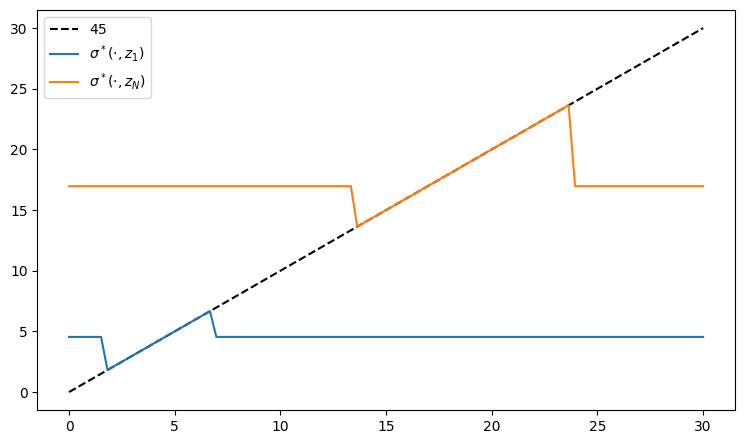

In [17]:
plot_policy()

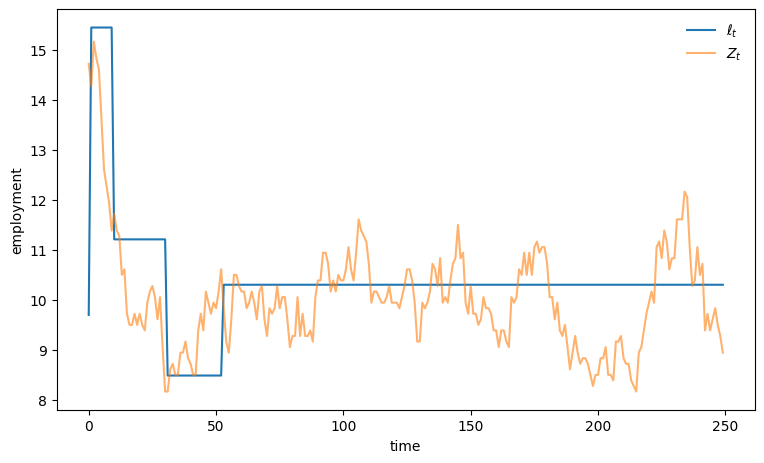

In [18]:
plot_sim(savefig=True)

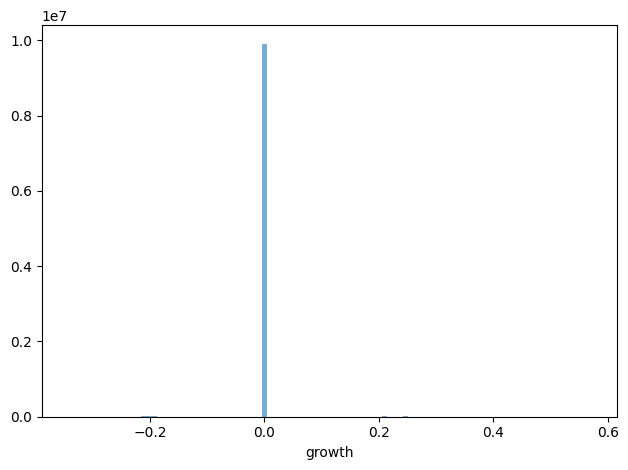

In [19]:
plot_growth(savefig=True)

In [20]:
from quantecon import tauchen, MarkovChain

import numpy as np
from collections import namedtuple
from numba import njit, prange
from math import floor


# NamedTuple Model
Model = namedtuple("Model", ("β", "γ", "η_grid", "φ",
                             "w_grid", "y_grid", "Q"))


def create_savings_model(β=0.98, γ=2.5,
                         w_min=0.01, w_max=20.0, w_size=100,
                         ρ=0.9, ν=0.1, y_size=20,
                         η_min=-0.25, η_max=0.25, η_size=30):
    η_grid = np.linspace(η_min, η_max, η_size)
    φ = np.ones(η_size) * (1 / η_size)  # Uniform distributoin
    w_grid = np.linspace(w_min, w_max, w_size)
    mc = tauchen(y_size, ρ, ν)
    y_grid, Q = np.exp(mc.state_values), mc.P
    return Model(β=β, γ=γ, η_grid=η_grid, φ=φ, w_grid=w_grid,
                 y_grid=y_grid, Q=Q)


## == Functions for regular OPI == ##

@njit
def U(c, γ):
    return c**(1-γ)/(1-γ)


@njit(parallel=True)
def B(i, j, k, l, v, model):
    """
    The function

    B(w, y, η, w′) = u(w + y - w′/η)) + β Σ v(w′, y′, η′) Q(y, y′) ϕ(η′)

    """
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    w, y, η, w_1 = w_grid[i], y_grid[j], η_grid[k], w_grid[l]
    c = w + y - (w_1 / η)
    exp_value = 0.0
    for m in prange(len(y_grid)):
        for n in prange(len(η_grid)):
            exp_value += v[l, m, n] * Q[j, m] * φ[n]
    return U(c, γ) + β * exp_value if c > 0 else -np.inf


@njit(parallel=True)
def T_σ(v, σ, model):
    """The policy operator."""
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    v_new = np.empty_like(v)
    for i in prange(len(w_grid)):
        for j in prange(len(y_grid)):
            for k in prange(len(η_grid)):
                v_new[i, j, k] = B(i, j, k, σ[i, j, k], v, model)
    return v_new


@njit(parallel=True)
def get_greedy(v, model):
    """Compute a v-greedy policy."""
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    w_n, y_n, η_n = len(w_grid), len(y_grid), len(η_grid)
    σ = np.empty((w_n, y_n, η_n), dtype=np.int32)
    for i in prange(w_n):
        for j in prange(y_n):
            for k in prange(η_n):
                _tmp = np.array([B(i, j, k, l, v, model) for l
                                in range(w_n)])
                σ[i, j, k] = np.argmax(_tmp)
    return σ


def optimistic_policy_iteration(model, tolerance=1e-5, m=100):
    """Optimistic policy iteration routine."""
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    w_n, y_n, η_n = len(w_grid), len(y_grid), len(η_grid)
    v = np.zeros((w_n, y_n, η_n))
    error = tolerance + 1
    while error > tolerance:
        last_v = v
        σ = get_greedy(v, model)
        for i in range(m):
            v = T_σ(v, σ, model)
        error = np.max(np.abs(v - last_v))
        print(f"OPI current error = {error}")
    return get_greedy(v, model)




## == Functions for modified OPI == ##


@njit
def D(i, j, k, l, g, model):
    """D(w, y, η, w′, g) = u(w + y - w′/η) + β g(y, w′)."""
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    w, y, η, w_1 = w_grid[i], y_grid[j], η_grid[k], w_grid[l]
    c = w + y - (w_1 / η)
    return U(c, γ) + β * g[j, l] if c > 0 else -np.inf


@njit(parallel=True)
def get_g_greedy(g, model):
    """Compute a g-greedy policy."""
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    w_n, y_n, η_n = len(w_grid), len(y_grid), len(η_grid)
    σ = np.empty((w_n, y_n, η_n), dtype=np.int32)
    for i in prange(w_n):
        for j in prange(y_n):
            for k in prange(η_n):
                _tmp = np.array([D(i, j, k, l, g, model) for l
                                in range(w_n)])
                σ[i, j, k] = np.argmax(_tmp)
    return σ


@njit(parallel=True)
def R_σ(g, σ, model):
    """The modified policy operator."""
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    w_n, y_n, η_n = len(w_grid), len(y_grid), len(η_grid)
    g_new = np.empty_like(g)
    for j in prange(y_n):
        for i_1 in prange(w_n):
            out = 0.0
            for j_1 in prange(y_n):
                for k_1 in prange(η_n):
                    out += D(i_1, j_1, k_1, σ[i_1, j_1, k_1], g,
                             model) * Q[j, j_1] * φ[k_1]
            g_new[j, i_1] = out
    return g_new


def mod_opi(model, tolerance=1e-5, m=100):
    """Modified optimistic policy iteration routine."""
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    g = np.zeros((len(y_grid), len(w_grid)))
    error = tolerance + 1
    while error > tolerance:
        last_g = g
        σ = get_g_greedy(g, model)
        for i in range(m):
            g = R_σ(g, σ, model)
        error = np.max(np.abs(g - last_g))
        print(f"OPI current error = {error}")
    return get_g_greedy(g, model)


def simulate_wealth(m):

    model = create_savings_model()
    σ_star = mod_opi(model)
    β, γ, η_grid, φ, w_grid, y_grid, Q = model

    # Simulate labor income
    mc = MarkovChain(Q)
    y_idx_series = mc.simulate(ts_length=m)

    # IID Markov chain with uniform draws
    l = len(η_grid)
    mc = MarkovChain(np.ones((l, l)) / l)
    η_idx_series = mc.simulate(ts_length=m)

    w_idx_series = np.empty_like(y_idx_series)
    w_idx_series[0] = 1  # initial condition
    for t in range(m-1):
        i, j, k = w_idx_series[t], y_idx_series[t], η_idx_series[t]
        w_idx_series[t+1] = σ_star[i, j, k]
    w_series = w_grid[w_idx_series]

    return w_series

def lorenz(v):  # assumed sorted vector
    S = np.cumsum(v)  # cumulative sums: [v[1], v[1] + v[2], ... ]
    F = np.arange(1, len(v) + 1) / len(v)
    L = S / S[-1]
    return (F, L) # returns named tuple

gini = lambda v: (2 * sum(i * y for (i, y) in enumerate(v))/sum(v) - (len(v) + 1))/len(v)

# Plots


import matplotlib.pyplot as plt


def plot_contours(savefig=False,
                  figname="../figures/modified_opt_savings_1.pdf"):

    model = create_savings_model()
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    σ_star = optimistic_policy_iteration(model)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    y_n, η_n = len(y_grid), len(η_grid)
    y_idx, η_idx = np.arange(y_n), np.arange(η_n)
    H = np.zeros((y_n, η_n))

    w_indices = (0, len(w_grid)-1)
    titles = "low wealth", "high wealth"
    for (ax, w_idx, title) in zip(axes, w_indices, titles):

        for i_y in y_idx:
            for i_η in η_idx:
                w, y, η = w_grid[w_idx], y_grid[i_y], η_grid[i_η]
                H[i_y, i_η] = w_grid[σ_star[w_idx, i_y, i_η]] / (w + y)

        cs1 = ax.contourf(y_grid, η_grid, np.transpose(H), alpha=0.5)

        plt.colorbar(cs1, ax=ax) #, format="%.6f")

        ax.set_title(title)
        ax.set_xlabel(r"$y$")
        ax.set_ylabel(r"$\varepsilon$")

    plt.tight_layout()
    if savefig:
        fig.savefig(figname)

def plot_policies(savefig=False):
    model = create_savings_model()
    β, γ, η_grid, φ, w_grid, y_grid, Q = model
    σ_star = mod_opi(model)
    y_bar = floor(len(y_grid) / 2) # index of mid-point of y_grid

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_grid, w_grid, "k--", label=r"$45$")

    for (i, η) in enumerate(η_grid):
        label = r"$\sigma^*$" + " at " + r"$\eta = $" + "$η"
        ax.plot(w_grid, w_grid[σ_star[:, y_bar, i]], label=label)
        
    ax.legend()
    if savefig:
        fig.savefig(f"../figures/modified_opt_saving_2.pdf")

def plot_time_series(m=2_000, savefig=False):

    w_series = simulate_wealth(m)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_series, label=r"w_t")
    ax.set_xlabel("time")
    ax.legend()
    if savefig:
        fig.savefig("../figures/modified_opt_saving_ts.pdf")

def plot_histogram(m=1_000_000, savefig=False):

    w_series = simulate_wealth(m)
    g = round(gini(w_series.sort()), ndigits=2)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.hist(w_series, bins=40, density=True)
    ax.set_xlabel("wealth")
    ax.text(15, 0.4, "Gini = $g")

    if savefig:
        fig.savefig("../figures/modified_opt_saving_hist.pdf")

def plot_lorenz(m=1_000_000, savefig=False):

    w_series = simulate_wealth(m)
    (F, L) = lorenz(w_series.sort())

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(F, F, label="Lorenz curve, equality")
    ax.plot(F, L, label="Lorenz curve, wealth distribution")
    ax.legend()

    if savefig:
        fig.savefig("../figures/modified_opt_saving_lorenz.pdf")

OPI current error = nan


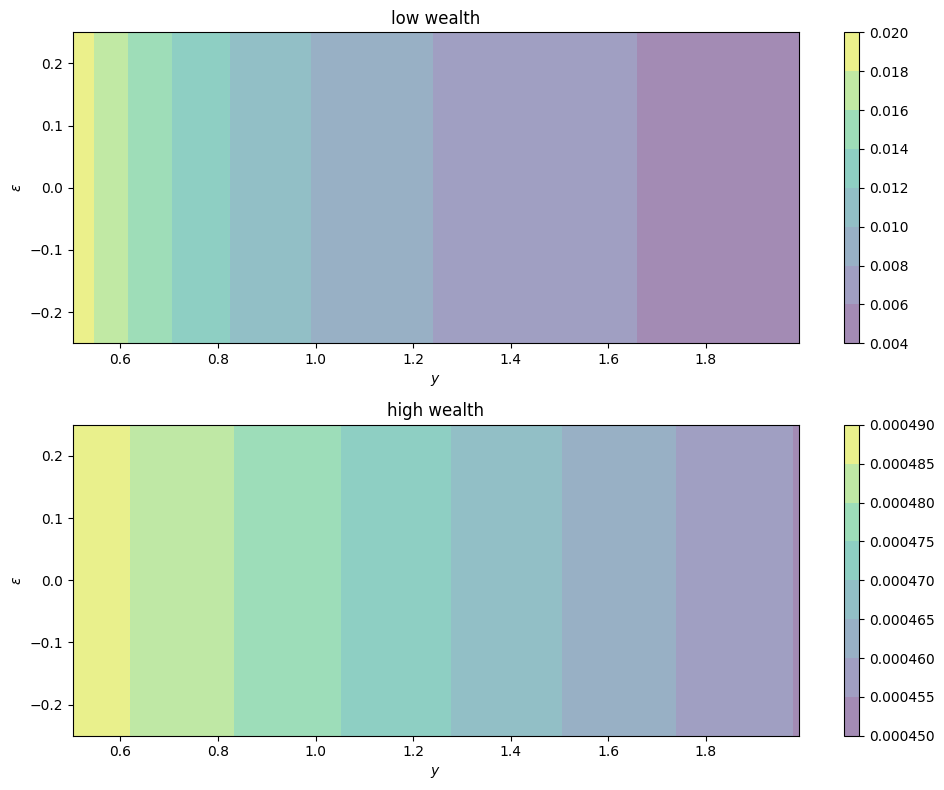

In [21]:
plot_contours(savefig=True)

OPI current error = nan


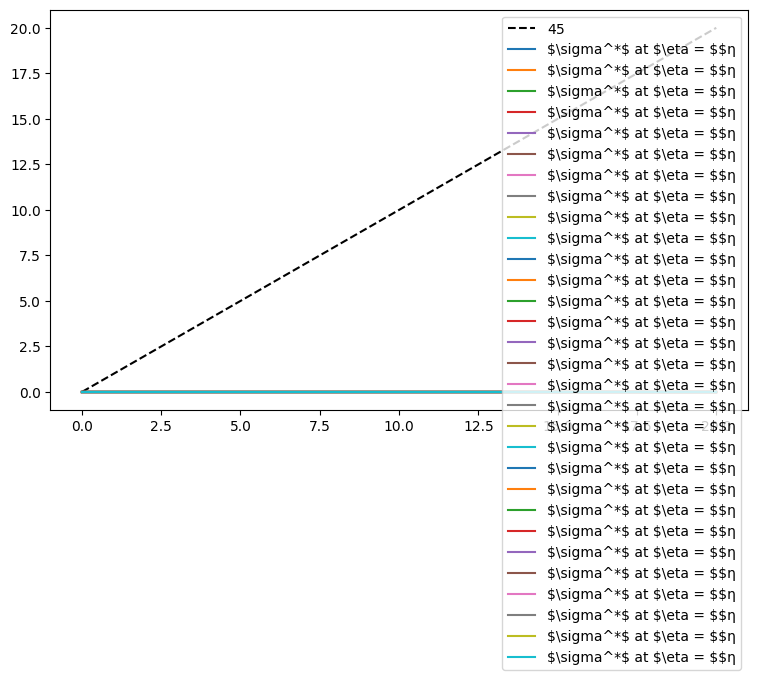

In [22]:
plot_policies(savefig=True)

OPI current error = nan


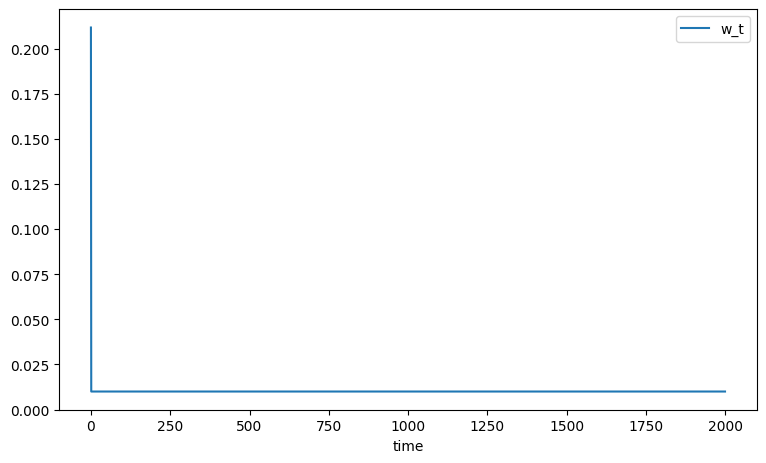

In [23]:
plot_time_series(savefig=True)

In [24]:
plot_histogram(savefig=True)

OPI current error = nan


TypeError: 'NoneType' object is not iterable

In [25]:
plot_lorenz(savefig=True)

OPI current error = nan


TypeError: object of type 'NoneType' has no len()